In [105]:
import numpy as np
import scipy as sc
import scipy.stats as sps
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import pandas as pd
import cvxpy as cvx
import cvxopt 
import sklearn.feature_selection as fs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mutual_info_score

%config InlineBackend.figure_format = 'retina'

In [96]:
%run numpy_nn.py

### Data

In [97]:
def generate_collinear_features(n, X):
    '''This is taken from Roman. Makes features correlated'''
    n_features = X.shape[1]
    X_new = np.zeros([X.shape[0], n])
    for i in range(n):
        n_cols = max(2, np.random.randint(n_features / 3) + 1)
        col_idxs = np.random.choice(np.arange(n_features), int(n_cols), replace=False)
        coef = np.random.rand(n_cols)
        coef /= np.sqrt(np.sum(coef ** 2))
        X_new[:, i] = X[:, col_idxs].dot(coef) 
    return X_new

In [98]:
def generate_y(X, coeffs = None):
    '''Generates y'''
    
    if coeffs is None:
        coeffs = sps.expon.rvs(size=(X.shape[1], 3)) # some_matrix just for testing
    ans = X @ coeffs
    error = sps.norm.rvs(scale=0.5, size=ans.shape)
    y = ans + error
    return y
    
    

In [99]:
def generate_correlated_data(n_samples, n_features, p=0.5, draw=True):
    '''Generates correlated data'''
    start_n_features = int(p * n_features)
    X = sps.norm.rvs(size=(n_samples, start_n_features))
    X_col = generate_collinear_features(n_features - start_n_features, X)
    X = np.hstack([X, X_col])
    if draw:
        plt.figure(figsize=(6, 5))
        plt.imshow(np.corrcoef(X.T))
        plt.xticks((0, 5, 10, 15), fontsize=16)
        plt.yticks((0, 5, 10, 15), fontsize=16)
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=16) 
        plt.tight_layout()
        plt.show()
    y = generate_y(X) # here can be something else
    return X, y

### Synthetic data

In [37]:
def get_test_train(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=179)
    return X_train, X_test, y_train, y_test

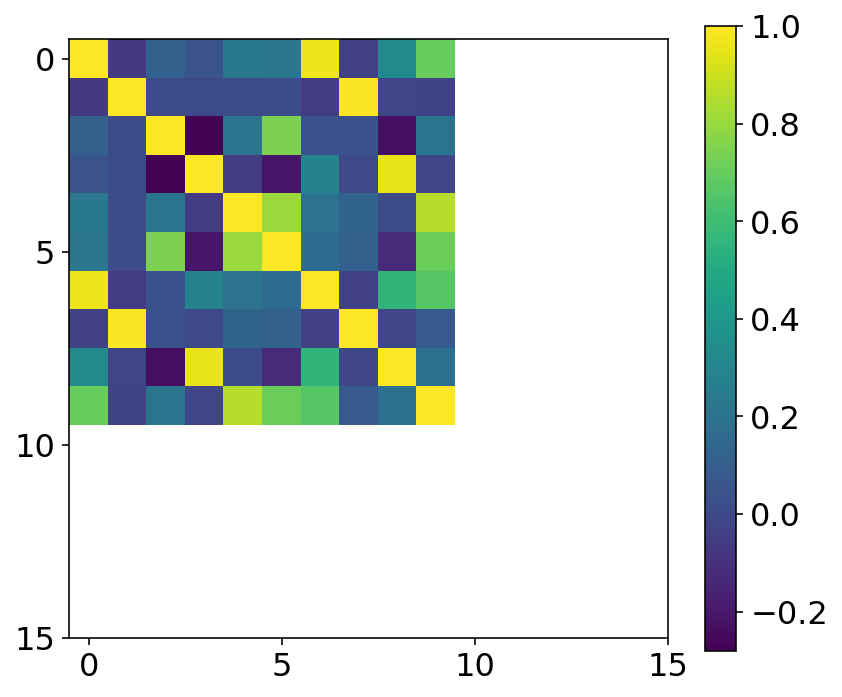

(50, 3)
(33, 3)


In [52]:
X, y = generate_correlated_data(50, 10)
print(y.shape)
X_train, X_test, y_train, y_test = get_test_train(X, y)
print(y_train.shape)

### Quadratic programming

In [128]:
def create_opt_problem(X, y, sim='correl', rel='correl', verbose=False):
    """
    % Function generates matrix Q and vector b
    % which represent feature similarities and feature relevances
    %
    % Input:
    % X - [m, n] - design matrix
    % y - [m, k] - target vector
    % sim - string - indicator of the way to compute feature similarities,
    % supported values are 'correl' and 'mi'
    % rel - string - indicator of the way to compute feature significance,
    % supported values are 'correl', 'mi' and 'lin-reg'
    % 
    % Defaults are 'correl'
    %
    % Output:
    % Q - [n ,n] - matrix of features similarities
    % b - [n, k] - vector of feature relevances
    """
    X = np.array(X)
    y = np.array(y)
    
    if verbose == True:
        print("Constructing the problem...")
        print('Similarity measure: %s, feature relevance measure: %s' % (sim, rel))
    
    if len(y.shape) == 1:
        y_mat = y[:, np.newaxis]
    else:
        y_mat = y[:]
    
    n = X.shape[0]
    m = X.shape[1]
    k = y_mat.shape[1]
    together = np.hstack([X, y_mat]).T
    
    if (sim == 'correl' or rel == 'correl'):
        cor = np.corrcoef(together)
    
    if sim == 'correl':
        Q = cor[:-k, :-k]
    elif rel == 'mi':
        Q = np.zeros((m, m))
        for i in range(m):
            for j in range(i, m):
                Q[i][j] = mutual_info_score(X[:, [i]].ravel(), X[:, [j]].ravel())
                Q[j][i] = Q[i][j]
    else:
        print("Wrong similarity measure")
        return
    
    if rel == 'correl':
        b = cor[:-k, -k:]
    elif rel == 'mi':
        b = np.zeros((m, k))
        for i in range(m):
            for j in range(k):
                b[i][j] = mutual_info_score(X[:, [i]].ravel(), y_mat[:, [j]].ravel())
        print(b.shape)
    elif rel == 'lin-reg':
        lr = LinearRegression()
        b = np.zeros((m, k))
        for i in range(m):
            for j in range(k):
                cur_y = y[:, [j]].ravel()
                lr.fit(X[:, [i]], cur_y)
                y_pred = lr.predict(X[:, [i]])
                b[i][j] = np.corrcoef(y_pred, cur_y)[0, 1]
        b = np.nan_to_num(b)
        print(b.shape)
    else:
        print("Wrong relevance measure")
        return
    
    b = np.abs(b).mean(axis=1)
    print()
        
    if verbose == True:
        print("Problem has been constructed.")
    return Q, np.abs(b)


def solve_opt_problem(Q, b, verbose=False):
    """
     Function solves the quadratic optimization problem stated to select
     significance and noncollinear features

     Input:
     Q - [n, n] - matrix of features similarities
     b - [n, 1] - vector of feature relevances

     Output:
     x - [n, 1] - solution of the quadratic optimization problem
    """
    
    n = Q.shape[0]
    x = cvx.Variable(n)
    
    objective = cvx.Minimize(cvx.quad_form(x, Q) - 1. * b.T * x)
    constraints = [x >= 0, x <= 1]
    prob = cvx.Problem(objective, constraints)
    
    if verbose == True:
        print("Solving the QP problem...")
    
    prob.solve()
    
    if verbose == True:
        print("The problem has been solved!")
        print("Problem status:", prob.status)
        print

    return np.array(x.value).flatten()
    
def quadratic_programming(X, y, sim='correl', rel='correl', verbose=False):
    Q, b = create_opt_problem(X, y, sim, rel, verbose)
    print
    qp_score = solve_opt_problem(Q, b, verbose)
    return qp_score

In [129]:
z = quadratic_programming(X_train, y_train, sim='mi', rel='mi', verbose=True)

Constructing the problem...
Similarity measure: mi, feature relevance measure: mi
(10, 3)

Problem has been constructed.
Solving the QP problem...
The problem has been solved!
Problem status: optimal


In [130]:
Q, b = create_opt_problem(X_train, y_train[:, 1], 'correl', 'correl')

In [131]:
z

array([ 0.04999997,  0.04999997,  0.04999997,  0.04999997,  0.04999997,
        0.04999997,  0.04999997,  0.04999997,  0.04999997,  0.04999997])

## Testing
